# ML Pipeline Example

In [1]:
# Imports
from ml_pipeline.preprocessing import transform_data, preprocess_data
from ml_pipeline.training import train_cross_validation
from ml_pipeline.evaluation import evaluate_models
from ml_pipeline.model import ModelWrapper

import pandas as pd
import numpy as np
import ezkl
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure

import torch
import torch.nn as nn


from pathlib import Path
import json
import os

base_folder = Path("notebooks/")
data_folder = base_folder / "data/"
zkml_folder = base_folder / "zkml/"

data_folder.mkdir(parents=True, exist_ok=True)
zkml_folder.mkdir(parents=True, exist_ok=True)


## 1. Read data

In [2]:
df = pd.read_csv(data_folder / "df_layer_zero_to_send_100k.csv")

In [3]:
df.head()

,month_start,User Address,Active Days,Active Months,Active Weeks,Amount of total transactions ($),Days since first activity,Days since last transaction,Interacted TX Contracts,Transactions Count,...,Active Days - past 6 windows,Active Months - past 3 windows,Active Months - past 6 windows,Active Weeks - past 3 windows,Active Weeks - past 6 windows,Trend Transactions - past 3 windows,Trend Transactions - past 6 windows,target,Transaction Points Dollars,Transaction Points Count
0,2023-08-01,0x0000000000003e6b8283d286abdbf9a6efa129d0,1.0,1.0,1.0,0.00,7,7,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,2023-03-01,0x000000000000d34c44564053af35e4fe271d0caa,1.0,1.0,1.0,6892.02,7,7,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1
2,2022-05-01,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,1.0,1.0,1.0,0.00,15,15,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,2023-05-01,0x0000000000163081ad5a1a8bf11955a908c1dbb4,1.0,1.0,1.0,16.35,9,9,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
4,2023-07-01,0x0000000000163081ad5a1a8bf11955a908c1dbb4,1.0,1.0,1.0,10.49,70,4,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1


In [4]:
df.describe()

,Active Days,Active Months,Active Weeks,Amount of total transactions ($),Days since first activity,Days since last transaction,Interacted TX Contracts,Transactions Count,Transactions Count - past 3 windows,Transactions Count - past 6 windows,...,Active Days - past 6 windows,Active Months - past 3 windows,Active Months - past 6 windows,Active Weeks - past 3 windows,Active Weeks - past 6 windows,Trend Transactions - past 3 windows,Trend Transactions - past 6 windows,target,Transaction Points Dollars,Transaction Points Count
count,100000.000000,100000.0,100000.000000,1.000000e+05,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,68330.000000,99994.000000,100000.0
mean,2.550460,1.0,1.775160,3.548337e+03,94.341700,18.33103,3.057990,6.07170,2.630473,0.702033,...,0.305357,0.339593,0.097948,0.738333,0.203388,0.316860,0.264013,0.589214,1.091716,1.0
std,2.707683,0.0,1.083678,4.723645e+05,89.046156,9.03676,3.239317,10.26125,5.815379,2.755566,...,1.041798,0.441312,0.264546,1.124521,0.607304,3.929901,3.823330,0.491980,0.680743,0.0
min,1.000000,1.0,1.000000,0.000000e+00,0.000000,0.00000,1.000000,1.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.990000,-0.982857,0.000000,0.000000,1.0
25%,1.000000,1.0,1.000000,1.900000e-01,24.000000,12.00000,1.000000,1.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.142857,0.000000,0.000000,1.000000,1.0
50%,2.000000,1.0,1.000000,1.499000e+01,71.000000,20.00000,2.000000,3.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0
75%,3.000000,1.0,2.000000,3.955700e+02,139.000000,26.00000,4.000000,7.00000,3.000000,0.000000,...,0.000000,1.000000,0.000000,1.333333,0.000000,0.000000,0.000000,1.000000,1.000000,1.0
max,31.000000,1.0,6.000000,1.416631e+08,621.000000,31.00000,108.000000,644.00000,327.333333,164.333333,...,21.166667,1.000000,1.000000,5.333333,5.166667,503.000000,335.000000,1.000000,6.000000,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   month_start                                        100000 non-null  object 
 1   User Address                                       100000 non-null  object 
 2   Active Days                                        100000 non-null  float64
 3   Active Months                                      100000 non-null  float64
 4   Active Weeks                                       100000 non-null  float64
 5   Amount of total transactions ($)                   100000 non-null  float64
 6   Days since first activity                          100000 non-null  int64  
 7   Days since last transaction                        100000 non-null  int64  
 8   Interacted TX Contracts                            100000 non-null  float64

In [6]:
df_to_ml = df[~df["month_start"].isin(["2023-09-01", "2023-10-01", "2023-11-01"])].fillna(0)
df_to_prod = df[df["month_start"].isin(["2023-10-01"])]

In [7]:
feature_selection = [
    col for col in df_to_ml.columns if df_to_ml[col].dtype in ["int64", "float64"]
    if col not in ["target"]
]

## 2. Data preprocessing

In [8]:
label_name = "target"

In [9]:
(
    train_X, 
    train_y, 
    test_X, 
    test_y, 
    group_kfold_splits, 
    (scaler, mean, std),
    train_index_new_order,
    test_index_new_order,
) = preprocess_data(
    data=df_to_ml,
    label_col=label_name,
    grouping_col="User Address",
    n_splits=5,
    test_size=0.1,
    feature_cols=feature_selection,
    do_feature_scaling=True,
    seed=1534,
)

Total elements: 68330
Test elements min: 6833

Final train elements: 61493 across 23163 groups
Final test elements: 6837 across 2611 groups

Elements in each fold:
Fold 0: 49194 (18530 groups), 12299 (4633 groups)
Fold 1: 49194 (18530 groups), 12299 (4633 groups)
Fold 2: 49194 (18530 groups), 12299 (4633 groups)
Fold 3: 49195 (18531 groups), 12298 (4632 groups)
Fold 4: 49195 (18531 groups), 12298 (4632 groups)

GroupKFold splits hash: fa0191d9a34c6feb9bd552ee6f1214eb


## 3. Model definition & training

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(24, 40)  # First hidden layer
        self.fc2 = nn.Linear(40, 40) # Second hidden layer
        self.fc3 = nn.Linear(40, 40) # Third hidden layer
        self.output = nn.Linear(40, 1) # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.output(x)
        return x

In [11]:
(
    models,
    train_loss_lists,
    train_accuracy_lists,
    valid_loss_lists,
    valid_accuracy_lists,
) = train_cross_validation(
    model_class=Model,
    train_X=train_X,
    train_y=train_y,
    group_kfold_splits=group_kfold_splits,
    batch_size=64,
    epochs=30,
    learning_rate=0.03,
    shuffle_batches=True,
)


Fold 0
Epoch: 0 Train loss: 0.6310 Validation loss: 0.6314
Epoch: 10 Train loss: 0.6154 Validation loss: 0.6235
Epoch: 20 Train loss: 0.6154 Validation loss: 0.6200
Fold 0 done, metrics:
  Train loss: 0.6164
  Validation loss: 0.6257
  Train accuracy: 0.6436
  Validation accuracy: 0.6411

Fold 1
Epoch: 0 Train loss: 0.6235 Validation loss: 0.6232
Epoch: 10 Train loss: 0.6159 Validation loss: 0.6162
Epoch: 20 Train loss: 0.6217 Validation loss: 0.6229
Fold 1 done, metrics:
  Train loss: 0.6084
  Validation loss: 0.6110
  Train accuracy: 0.6509
  Validation accuracy: 0.6510

Fold 2
Epoch: 0 Train loss: 0.6231 Validation loss: 0.6273
Epoch: 10 Train loss: 0.6101 Validation loss: 0.6130
Epoch: 20 Train loss: 0.6104 Validation loss: 0.6164
Fold 2 done, metrics:
  Train loss: 0.6141
  Validation loss: 0.6229
  Train accuracy: 0.6585
  Validation accuracy: 0.6546

Fold 3
Epoch: 0 Train loss: 0.6253 Validation loss: 0.6247
Epoch: 10 Train loss: 0.6229 Validation loss: 0.6238
Epoch: 20 Train l

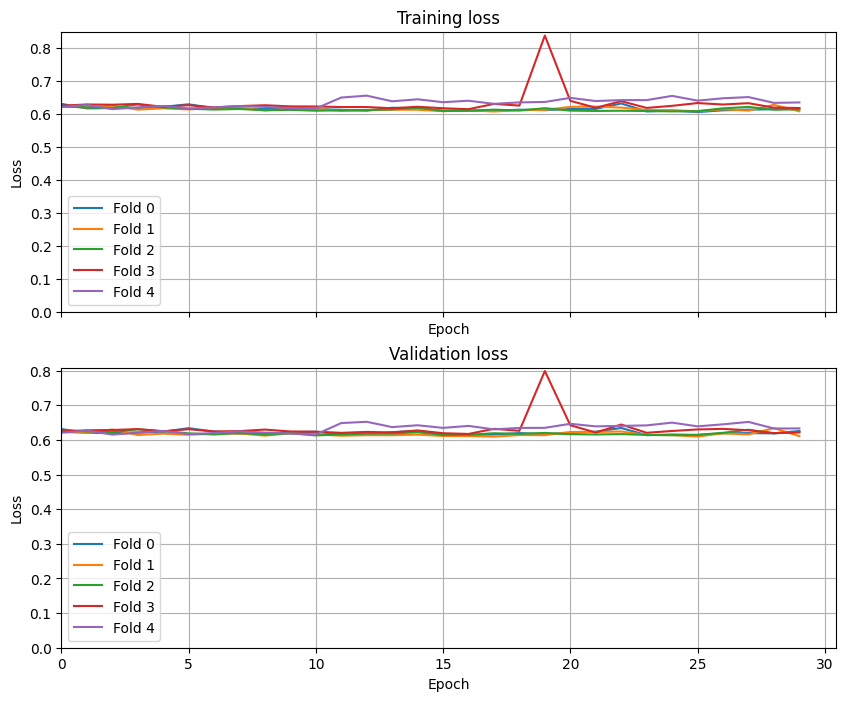

In [12]:
# Plot the loss evolution for all folds

# First the training loss
fig = plt.figure(figsize=(10, 8))
axes: list[Axes] = fig.subplots(2, 1, sharex=True)
ax = axes[0]
for i, train_loss_list in enumerate(train_loss_lists):
    ax.plot(train_loss_list, label=f"Fold {i}")
ax.set_title("Training loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.grid()

# Then the validation loss
ax = axes[1]
for i, valid_loss_list in enumerate(valid_loss_lists):
    ax.plot(valid_loss_list, label=f"Fold {i}")
ax.set_title("Validation loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.grid()
plt.show()


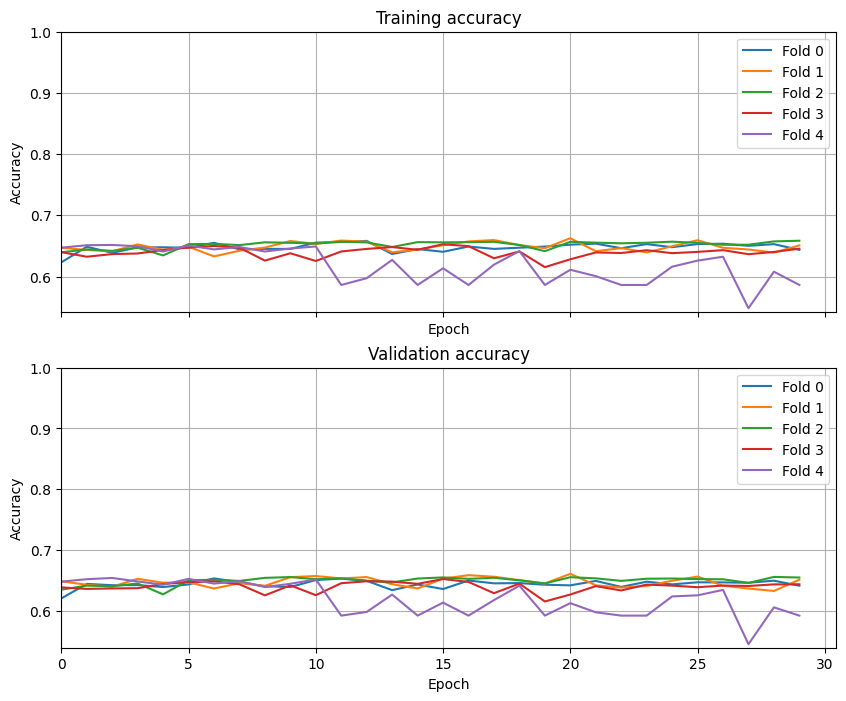

In [13]:
# Now the accuracy evolution for all folds
# Plot the loss evolution for all folds

# First the training loss
fig = plt.figure(figsize=(10, 8))
axes: list[Axes] = fig.subplots(2, 1, sharex=True)
ax = axes[0]
for i, train_accuracy_list in enumerate(train_accuracy_lists):
    ax.plot(train_accuracy_list, label=f"Fold {i}")
ax.set_title("Training accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()
ax.set_ylim(top=1)
ax.set_xlim(left=0)
ax.grid()

# Then the validation loss
ax = axes[1]
for i, valid_accuracy_list in enumerate(valid_accuracy_lists):
    ax.plot(valid_accuracy_list, label=f"Fold {i}")
ax.set_title("Validation accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()
ax.set_ylim(top=1)
ax.set_xlim(left=0)
ax.grid()
plt.show()

## 4. Model evaluation

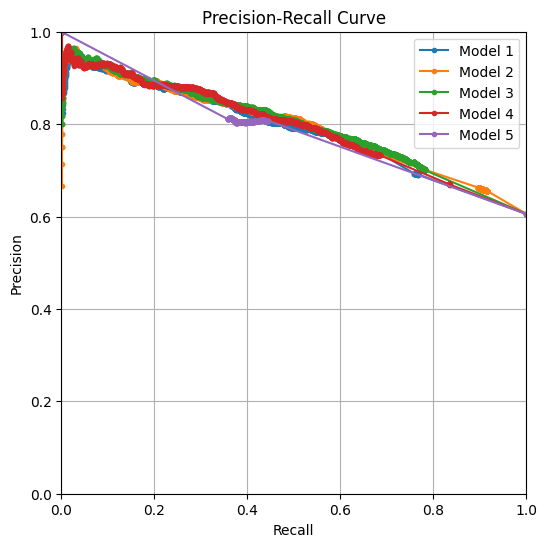

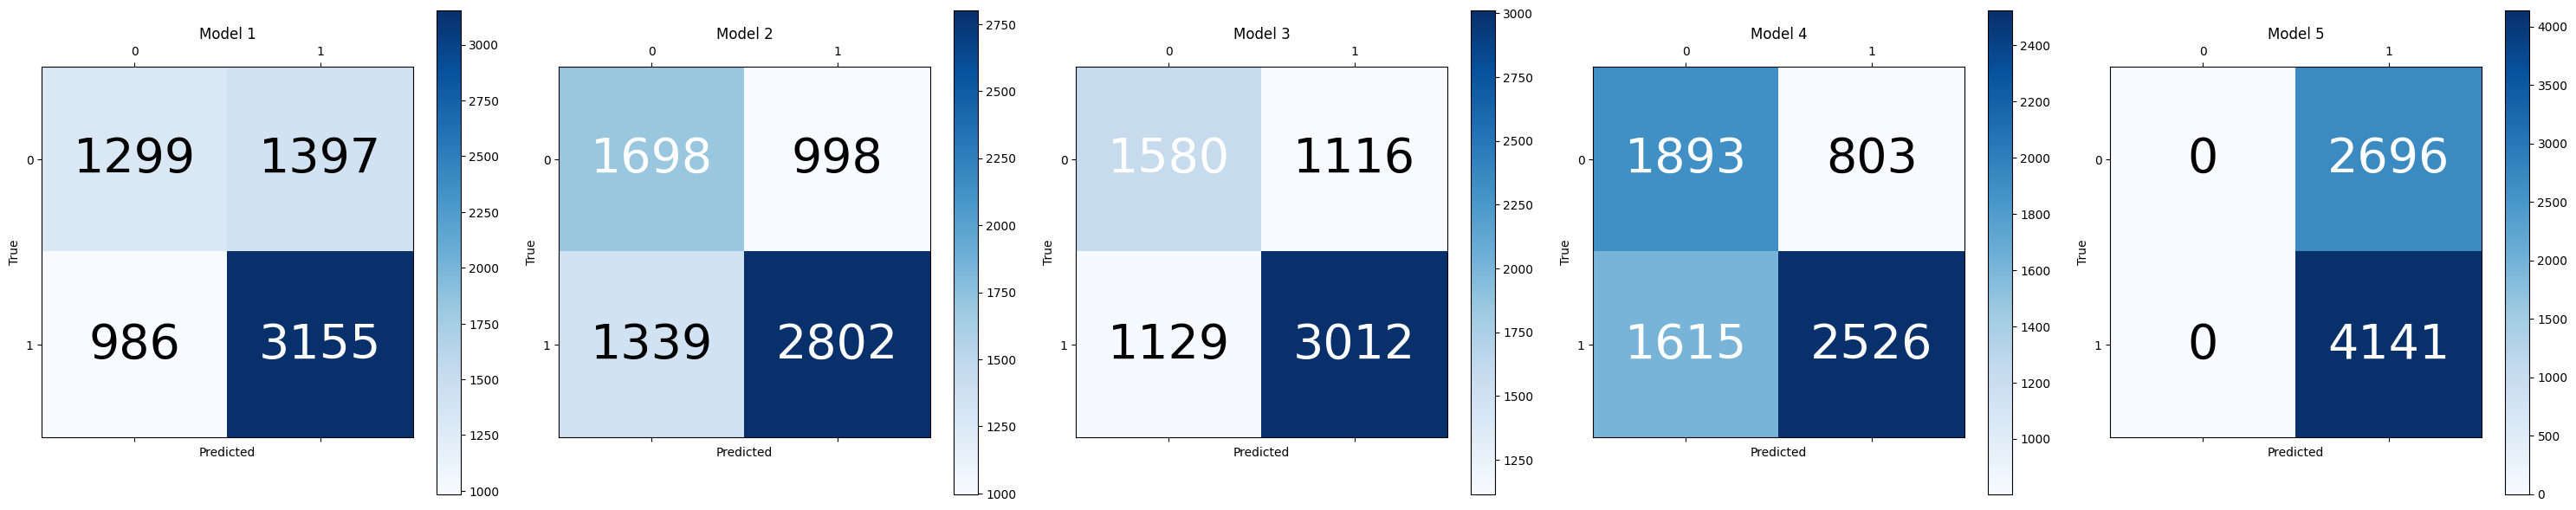

Classification Report for Model 1:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52      2696
           1       0.69      0.76      0.73      4141

    accuracy                           0.65      6837
   macro avg       0.63      0.62      0.62      6837
weighted avg       0.64      0.65      0.65      6837

Classification Report for Model 2:
              precision    recall  f1-score   support

           0       0.56      0.63      0.59      2696
           1       0.74      0.68      0.71      4141

    accuracy                           0.66      6837
   macro avg       0.65      0.65      0.65      6837
weighted avg       0.67      0.66      0.66      6837

Classification Report for Model 3:
              precision    recall  f1-score   support

           0       0.58      0.59      0.58      2696
           1       0.73      0.73      0.73      4141

    accuracy                           0.67      6837
   macro avg       0.66

/Users/miguel/Library/Caches/pypoetry/virtualenvs/ethglobal-istanbul-2023-fCBdT8rQ-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/miguel/Library/Caches/pypoetry/virtualenvs/ethglobal-istanbul-2023-fCBdT8rQ-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/miguel/Library/Caches/pypoetry/virtualenvs/ethglobal-istanbul-2023-fCBdT8rQ-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defi

In [14]:
evaluate_models(models, test_X, test_y)

In [15]:
# select one of the models once you are happy with the results
final_model: nn.Module = models[3]

# save the model
model_scripted = torch.jit.script(final_model) # Export to TorchScript
model_scripted.save(base_folder/ "models" / "model_scripted.pt")

## 5. SHAP

In [16]:
import shap
import torch
import matplotlib.pyplot as plt
from typing import Union, List


class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        logits = self.model(x)
        probabilities = torch.sigmoid(logits)
        return probabilities


def calculate_shap_values(model: nn.Module, X: torch.Tensor):
    # Ensure the model is in evaluation mode
    model.eval()

    # Wrap the model with a GradientExplainer
    explainer = shap.GradientExplainer(model, X)

    # Get SHAP values for the specific input sample
    shap_values = explainer.shap_values(X)

    return shap_values


def display_beeswarm(
    model: nn.Module,
    data_X: torch.Tensor,
    feature_names: Union[List[str], None] = None,
    shap_values: Union[np.ndarray, None] = None,
):
    if shap_values is None:
        shap_values = calculate_shap_values(model, data_X)

    if not feature_names:
        feature_names = [f"Feature_{i}" for i in range(data_X.shape[1])]

    # Plotting the beeswarm plot
    shap.summary_plot(
        shap_values,
        features=data_X,
        feature_names=feature_names,
    )
    plt.show()

def display_waterfall(
    shap_values: np.ndarray,
    model: nn.Module,
    X: torch.Tensor,
    idx: int,
    feature_names: Union[List[str], None] = None,
    max_display: int = 10,
):
    # Calculate the expected value (mean model output on train data)
    with torch.no_grad():
        expected_value = model(X).mean().item()

    if not feature_names:
        feature_names = [f"Feature_{i}" for i in range(input_sample.shape[1])]

    input_sample = X[idx].unsqueeze(0)

    # Prepare the SHAP explanation object
    shap_explanation = shap.Explanation(
        values=shap_values[0].squeeze(),  # Adjust based on your output shape
        base_values=expected_value,
        data=input_sample.numpy().squeeze(),  # Adjust as needed
        feature_names=feature_names,
    )

    # Create the waterfall plot
    shap.waterfall_plot(
        shap_explanation,
        max_display=max_display,
        show=False,
    )
    plt.show()



In [17]:
all_X = torch.cat([train_X, test_X])[:1000]
shap_values = calculate_shap_values(final_model, all_X)

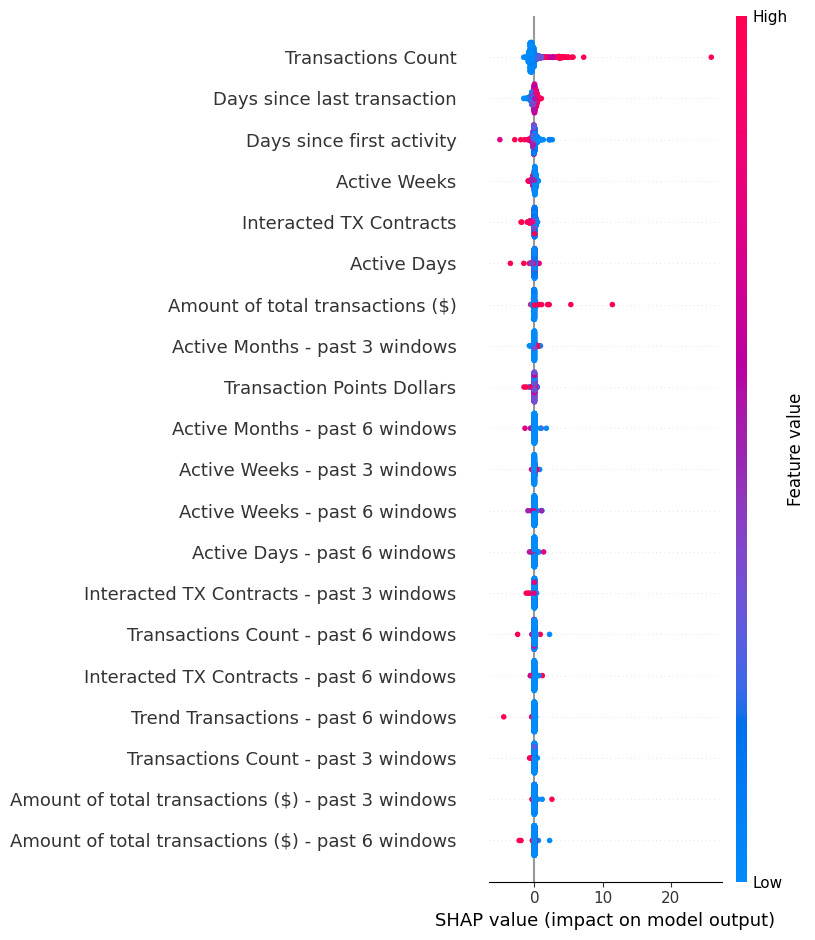

In [18]:
display_beeswarm(ModelWrapper(final_model), all_X, feature_selection, shap_values)

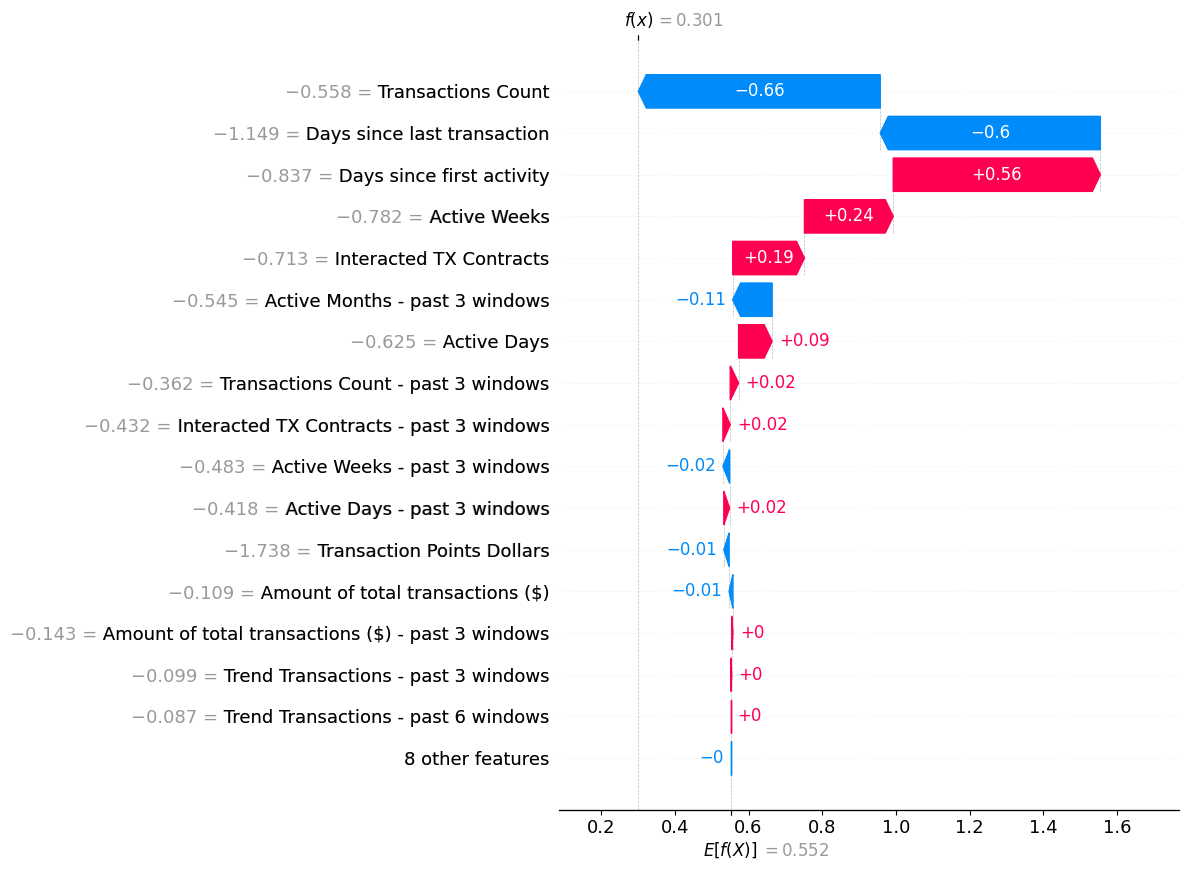

In [19]:
display_waterfall(
    shap_values,
    ModelWrapper(final_model),
    all_X,
    0,
    feature_selection,
    max_display=17,
)

## 6. ZKML model serialization

In [20]:
model_path = zkml_folder / "network.onnx"
compiled_model_path = zkml_folder / "network.ezkl"
pk_path = zkml_folder / "key.pk"
vk_path = zkml_folder / "key.vk"
settings_path = zkml_folder / "settings.json"
srs_path = zkml_folder / "kzg.srs"
witness_path = zkml_folder / "witness.json"
data_path = zkml_folder / "input_data.json"
cal_data_path = zkml_folder / "cal_data.json"
proof_path = zkml_folder / "proof.json"
proof_data_path = zkml_folder / "proof_data.json"

In [21]:
sample_input = test_X[0].reshape(1, -1)

data_array = (sample_input.detach().numpy()).reshape([-1]).tolist()

data = dict(input_data=[data_array])

# Serialize data into file:
with data_path.open("w") as f:
    json.dump(data, f)


# use the test set to calibrate the circuit
cal_data = dict(input_data=test_X.flatten().tolist())

# Serialize calibration data into file:
json.dump(data, open(cal_data_path, "w"))

In [22]:
final_model.eval()

torch.onnx.export(
    final_model,  # model being run
    sample_input,  # model input (or a tuple for multiple inputs)
    model_path,  # where to save the model (can be a file or file-like object)
    export_params=True,  # store the trained parameter weights inside the model file
    opset_version=10,  # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names=["input"],  # the model's input names
    output_names=["output"],  # the model's output names
    dynamic_axes={
        "input": {0: "batch_size"},  # variable length axes
        "output": {0: "batch_size"},
    },
)

In [23]:
# concat test_X and train_X
all_X = torch.cat((test_X, train_X), 0)

proof_input = all_X
proof_data_array = proof_input.detach().numpy().tolist()
proof_data = dict(input_data=proof_data_array)

with proof_data_path.open("w") as f:
    json.dump(proof_data, f)

In [24]:
py_run_args = ezkl.PyRunArgs()
py_run_args.input_visibility = "public"
py_run_args.output_visibility = "public"
py_run_args.param_visibility = "fixed" # "fixed" for params means that the committed to params are used for all proofs

res = ezkl.gen_settings(model_path, settings_path, py_run_args=py_run_args)
assert res == True, "Failed to generate settings"

res = await ezkl.calibrate_settings(cal_data_path, model_path, settings_path, "resources")
assert res == True, "Failed to calibrate settings"

In [25]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

In [26]:
res = ezkl.get_srs(srs_path, settings_path)

In [27]:
res = ezkl.setup(
    compiled_model_path,
    vk_path,
    pk_path,
    srs_path,
)


assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

spawning module 2
spawning module 2


In [28]:
# Generate the Witness for the proof

# now generate the witness file
res = ezkl.gen_witness(proof_data_path, compiled_model_path, witness_path)
assert witness_path.is_file()

In [29]:
# Generate the proof

proof = ezkl.prove(
    witness_path,
    compiled_model_path,
    pk_path,
    proof_path,
    srs_path,
    "single",
)

print(proof)
assert os.path.isfile(proof_path)

spawning module 2


{'instances': [[[4476394681747374096, 9457141985490438420, 9584886409590048210, 451740047718875803], [0, 0, 0, 0], [4476394681747374096, 9457141985490438420, 9584886409590048210, 451740047718875803], [0, 0, 0, 0], [4476394681747374096, 9457141985490438420, 9584886409590048210, 451740047718875803], [10902020042510041094, 17381486299841078119, 5900175412809962030, 2475245527108272378], [4476394681747374096, 9457141985490438420, 9584886409590048210, 451740047718875803], [16912579398983483403, 13419314142665758269, 16965902948054780928, 1463492787413574090], [10902020042510041094, 17381486299841078119, 5900175412809962030, 2475245527108272378], [10902020042510041094, 17381486299841078119, 5900175412809962030, 2475245527108272378], [10902020042510041094, 17381486299841078119, 5900175412809962030, 2475245527108272378], [0, 0, 0, 0], [16912579398983483403, 13419314142665758269, 16965902948054780928, 1463492787413574090], [10902020042510041094, 17381486299841078119, 5900175412809962030, 247524

In [30]:
# verify our proof

res = ezkl.verify(
    proof_path,
    settings_path,
    vk_path,
    srs_path,
)

assert res == True
print("verified")

verified


## 7. Generate output for backend

In [31]:
X_to_prod = transform_data(df_to_prod, feature_selection, scaler)

In [32]:
prod_predictions = ModelWrapper(final_model)(X_to_prod).detach().numpy().flatten()

In [33]:
# insert all_predictions into df using the index (concat train_index_new_order and test_index_new_order)

df_final = df_to_prod.copy()
df_final["prediction"] = prod_predictions

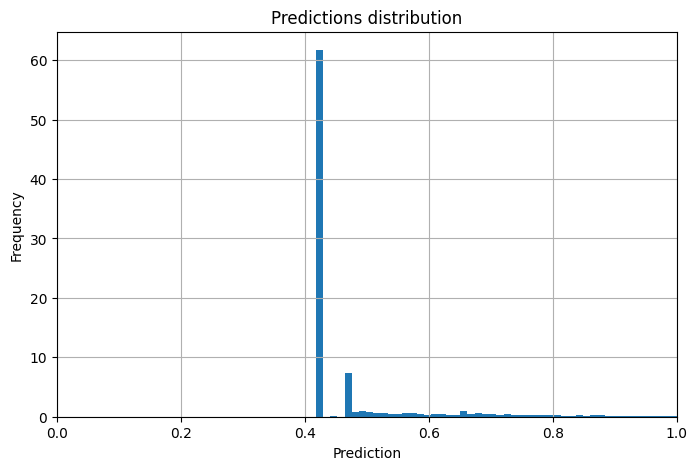

In [34]:
fig, ax = plt.subplots(figsize=(8, 5))
ax: Axes
ax.hist(df_final["prediction"], bins=50, density=True)
ax.set_title("Predictions distribution")
ax.set_xlabel("Prediction")
ax.set_ylabel("Frequency")
ax.grid()
ax.set_xlim(0, 1)

plt.show()

In [35]:
df_final["Transactions Count"]

7         1.0
13        2.0
20        2.0
52        7.0
70        9.0
         ... 
99950     1.0
99953     3.0
99979     1.0
99984     6.0
99992    13.0
Name: Transactions Count, Length: 10762, dtype: float64

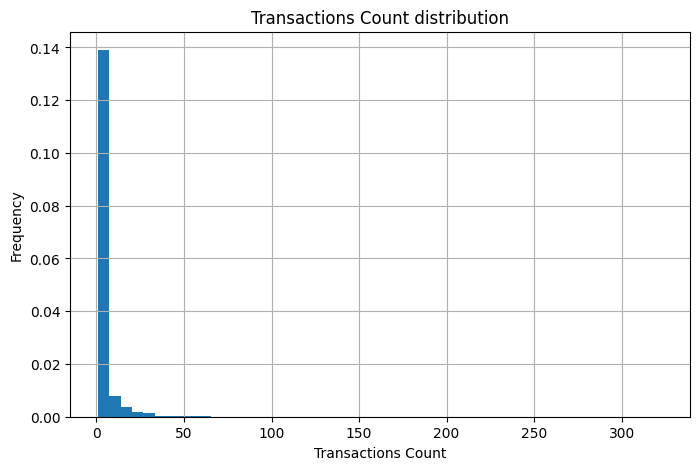

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))
ax: Axes
ax.hist(df_final["Transactions Count"], bins=50, density=True)
ax.set_title("Transactions Count distribution")
ax.set_xlabel("Transactions Count")
ax.set_ylabel("Frequency")
ax.grid()

plt.show()

In [37]:
user_probas = {
    row["User Address"]: float(row["prediction"]) for _, row in df_final.iterrows()
}

In [38]:
from typing import Any


def generate_user_groups(
    groups: list[tuple[str, float, float]], 
    data: pd.DataFrame,
    prediction_col: str,
    value_col: str,
) -> list[dict[str, Any]]:
    groups_data = []
    for label, lower, higher in groups:
        data_group = data[(data[value_col] >= lower) & (data[value_col] < higher)]
        count = len(data_group)
        mean = data_group[prediction_col].mean()
        median = data_group[prediction_col].median()
        pct25 = data_group[prediction_col].quantile(0.25)
        pct75 = data_group[prediction_col].quantile(0.75)
        pct10 = data_group[prediction_col].quantile(0.1)
        pct90 = data_group[prediction_col].quantile(0.9)
        total_value = data_group[value_col].sum()
        mean_value = data_group[value_col].mean()
        median_value = data_group[value_col].median()
        group_data = {
            "label": label,
            "lower": float(lower),
            "higher": float(higher),
            "count": float(count),
            "mean": float(mean),
            "median": float(median),
            "pct25": float(pct25),
            "pct75": float(pct75),
            "pct10": float(pct10),
            "pct90": float(pct90),
            "value_generated": float(total_value),
            "value_generated_mean": float(mean_value),
            "value_generated_median": float(median_value),
        }
        groups_data.append(group_data)

    while groups_data[-1]["count"] == 0:
        groups_data.pop()

    return groups_data


In [39]:
user_groups = generate_user_groups(
    groups = [
        ("1 - 5", 1, 5),
        ("5 - 20", 5, 20),
        ("20 - 50", 20, 50),
        ("50 - 100", 50, 100),
        ("100+", 100, 10000000000),
    ],
    data = df_final,
    prediction_col = "prediction",
    value_col = "Transactions Count",
)

In [40]:
final_data = {
    "user_probas": user_probas,
    "user_groups": user_groups
}

In [41]:
# save final_data to json in the data folder as prod_data.json
with (data_folder / "prod_data.json").open("w") as f:
    json.dump(final_data, f)